In [182]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['depths.csv', 'test', 'train', 'train.csv', 'sample_submission.csv']


In [183]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import keras
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

In [184]:
#Preparing data and masks
def data(dir_data):
    Images = []
        
    for image_file in os.listdir(dir_data): 
        image = cv2.imread(dir_data+r'/'+image_file) 
        image = cv2.resize(image,(128,128)) 
        Images.append(image)
    
    return shuffle(Images,random_state=3) 

def mask(dir_mask):
    Masks = []
    GrayMasks=[]    
    for image_file in os.listdir(dir_mask): 
        mask = cv2.imread(dir_mask+r'/'+image_file, cv2.IMREAD_GRAYSCALE) 
        mask = cv2.resize(mask,(128,128)) 
        Masks.append(mask)
    return shuffle(Masks,random_state=3) 

In [185]:
#printing shapes of input images
Images = data('../input/train/images')
Images = np.array(Images)

trainImages=Images[0:3500]
valImages=Images[3500:]
print("Train Images : ",trainImages.shape)
print("Val Images : ",valImages.shape)

Train Images :  (3500, 128, 128, 3)
Val Images :  (500, 128, 128, 3)


In [186]:
#printing shapes of input Masks and preparing them for segmnetation
Masks = mask('../input/train/masks')
Masks = np.array(Masks)

for i in range(0,Masks.shape[0]):
    for j in range(0,Masks.shape[1]):
        for k in range(0,Masks.shape[2]):
            if Masks[i,j,k]>0:
                Masks[i,j,k]=1
            else:
                Masks[i,j,k]=0

print(" Masks : ",Masks.shape)  
print("Unique values in masks : ",np.unique(Masks)) 

 Masks :  (4000, 128, 128)
Unique values in masks :  [0 1]


In [201]:
#printing shapes of input masks 
trainMasks=Masks[0:3500]
valMasks=Masks[3500:]
print("Train mask : ",trainMasks.shape)
print("Val mask : ",valMasks.shape)


Train mask :  (3500, 128, 128)
Val mask :  (500, 128, 128)


In [202]:
def plot2x2Array(image, mask, true):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    if true==1:
        axarr[1].set_title('True Mask')
    if true==0:
        axarr[1].set_title('predicted Mask')



Yellow(1) for salt and Purple(0) for background


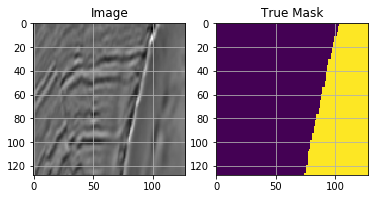

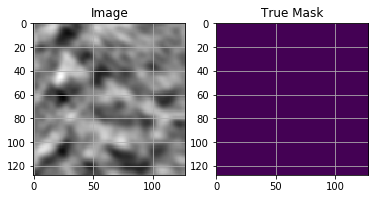

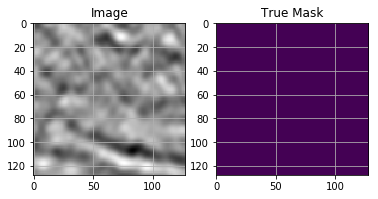

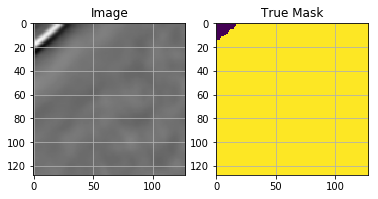

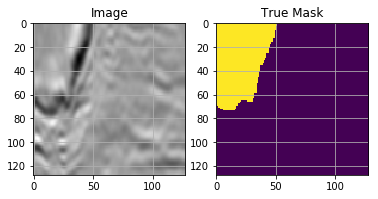

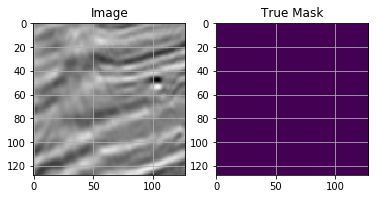

In [203]:
#Visualizing randomly 6 images with their masks
print("Yellow(1) for salt and Purple(0) for background")
for i in range(3):
    n=np.random.randint(1,3500)
    image = trainImages[n]
    mask = trainMasks[n]
    plot2x2Array(image, mask, 1)
    
    
for i in range(3):
    n=np.random.randint(1,500)
    image = valImages[n]
    mask = valMasks[n]
    plot2x2Array(image, mask, 1) 

In [204]:
#reshaping for ConvNet
trainMasks=trainMasks.reshape(trainMasks.shape[0],128,128,1)
#valMasks=valMasks.reshape(valMasks.shape[0],128,128,1)
print("Train mask : ",trainMasks.shape)
print("Val mask : ",valMasks.shape)

Train mask :  (3500, 128, 128, 1)
Val mask :  (500, 128, 128)


In [205]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [206]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((128, 128, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [207]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 128, 128, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_134[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
conv2d_136

In [208]:
model.fit(x=trainImages, y=trainMasks, batch_size=16, epochs=25, verbose=1, callbacks=None, 
          validation_split=0.1, validation_data=None, shuffle=True, class_weight=None, 
          sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

Train on 3150 samples, validate on 350 samples
Epoch 1/25
3150/3150 [==============================] - 8s 3ms/step - loss: 0.5746 - acc: 0.7437 - val_loss: 0.4998 - val_acc: 0.7527
Epoch 2/25
3150/3150 [==============================] - 6s 2ms/step - loss: 0.5068 - acc: 0.7600 - val_loss: 0.4687 - val_acc: 0.7930
Epoch 3/25
3150/3150 [==============================] - 6s 2ms/step - loss: 0.4613 - acc: 0.7909 - val_loss: 0.4645 - val_acc: 0.7861
Epoch 4/25
3150/3150 [==============================] - 6s 2ms/step - loss: 0.4129 - acc: 0.8274 - val_loss: 0.3967 - val_acc: 0.8371
Epoch 5/25
3150/3150 [==============================] - 6s 2ms/step - loss: 0.3980 - acc: 0.8341 - val_loss: 0.3868 - val_acc: 0.8410
Epoch 6/25
3150/3150 [==============================] - 6s 2ms/step - loss: 0.3454 - acc: 0.8720 - val_loss: 0.4285 - val_acc: 0.8652
Epoch 7/25
3150/3150 [==============================] - 6s 2ms/step - loss: 0.3354 - acc: 0.8763 - val_loss: 0.3074 - val_acc: 0.8823
Epoch 8/25
3150

In [209]:
## Save the Weights
model.save_weights("UNetW.h6")

## Dataset for prediction
result = model.predict(valImages)

result = result > 0.5
result=result.reshape(valImages.shape[0],128,128)

Yellow(1) for salt and Purple(0) for background


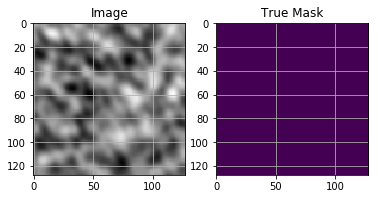

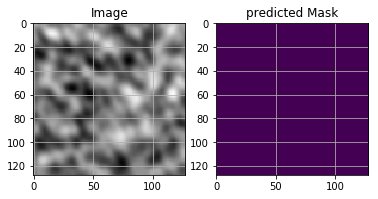

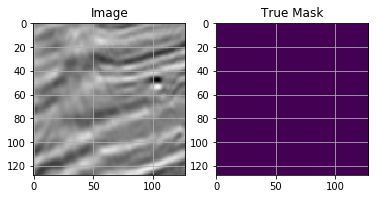

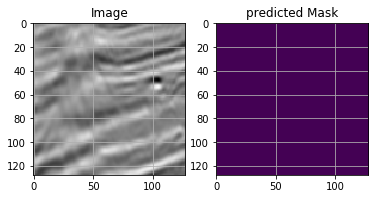

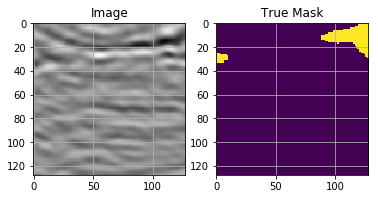

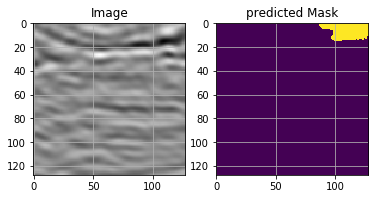

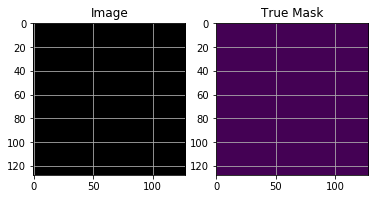

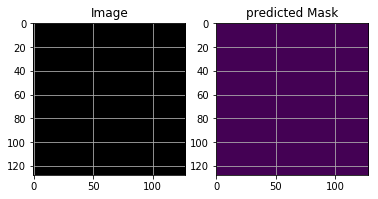

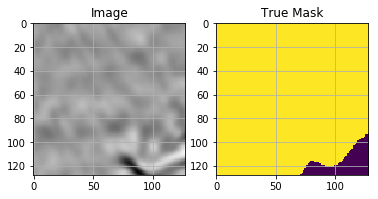

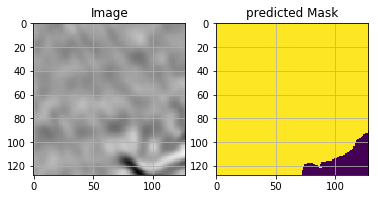

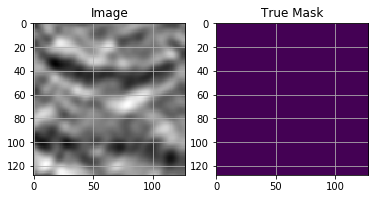

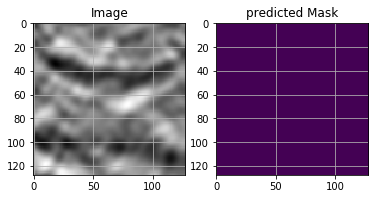

In [210]:
#Visualizing randomly 6 images with their masks as well as predicted masks
print("Yellow(1) for salt and Purple(0) for background")
for i in range(6):
    n=np.random.randint(1,valImages.shape[0])
    plot2x2Array(valImages[n],valMasks[n], 1)
    plot2x2Array(valImages[n],result[n], 0)
    